# From raw text to understanding.

### An NLP workshop by Mouad Hadji - [@itismouad](https://twitter.com/itismouad), Senior Data Scientist at Tesla

This code is showcase of the diverse *natural language processing* techniques one can use to :
- automatically classify sentences depending on the sentiment or category
- extract representation of words and sentences to understand text
- etc.

## 0. loading packages

In [285]:
import os, sys
import codecs
import gensim
import pickle
import nltk
import string
import random
import sqlite3
import time
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
'''Reproducibility settings'''
random.seed(100)

In [118]:
PRESENTATION_MODE=True

## 1. loading and quick inspection of data

We start here by loading our dataset stored in a sqlite database and inspect very quickly. We also load the config path where we will store any (hyper-)parameters or parameters we will be willing to use later in our code.

In [245]:
data_path = '../data'
model_path = '../model'
config_path = '../config'

### 👉 quick description

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories. As a reminder it can be found [here](https://www.kaggle.com/snap/amazon-fine-food-reviews) on kaggle or [here](http://snap.stanford.edu/data/web-FineFoods.html) on SNAP (original source).

This dataset consists of a single table, **Reviews**.

In [4]:
con = sqlite3.connect(os.path.join(data_path, 'database.sqlite'))
cursor = con.cursor()

In [5]:
%time table = pd.read_sql_query("SELECT * FROM Reviews;", con)

CPU times: user 3.57 s, sys: 1.14 s, total: 4.71 s
Wall time: 5.69 s


In [6]:
table.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

### 👉 perfect showcase

The columns in the table are:

- `Id`
- `ProductId` - unique identifier for the product
- `UserId` - unqiue identifier for the user
- `ProfileName`
- `HelpfulnessNumerator` - number of users who found the review helpful
- `HelpfulnessDenominator` - number of users who indicated whether they found the review helpful
- `Score` - rating between 1 and 5
- `Time` - timestamp for the review
- `Summary` - brief summary of the review
- `Text` - text of the review


This is a perfect example of dataset that a business might be able to gather by sending survey to its customers. We have a `Score` that we can use to create sentiment categories (positive/neutral/negative) and we have a free-text field `Text` where customers can freely enter a review. Data will probably be *messy* and unbalanced (like usual), hence the perfect showcase here.

In [7]:
table.describe()

Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09

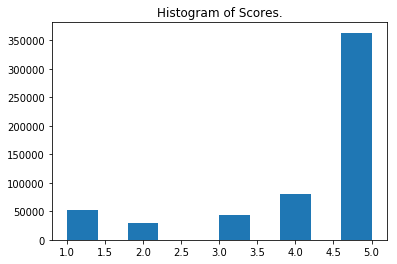

In [8]:
plt.hist(table.Score)
plt.title("Histogram of Scores.")
plt.show()

### 👉 preparing for sentiment classification

We can assume that a score of 4 or greater is *Positive* and that a score lower than 3 strictly is *Negative*. The rest will be *Neutral*

In [9]:
def assign_sentiment(score, label=False):
    if score > 3:
        return "Positive" if not label else 1
    elif score < 3:
        return "Negative" if not label else 3
    else:
        return "Neutral" if not label else 2

In [10]:
table['Sentiment'] = table.Score.apply(assign_sentiment)
table['ClassLabel'] = table.Score.apply(assign_sentiment, label=True)

In [11]:
table.Sentiment.value_counts()

Positive    443777
Negative     82037
Neutral      42640
Name: Sentiment, dtype: int64

As predicted, the dataset is completely imbalanced. We will balance it later probably by sub-sampling here but we can also make use of different sampling techniques such as SMOTE (see the [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/) package for more detailed and this paper on [SMOTE](https://www.jair.org/media/953/live-953-2037-jair.pdf)).

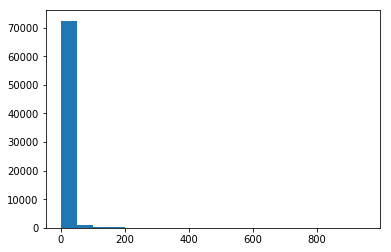

In [12]:
plt.hist([table.ProductId.value_counts()], bins=np.arange(0,1000,50))
plt.show()

In [13]:
data = table[['ProductId', 'Score', 'Summary', 'Text', 'Sentiment', 'ClassLabel']]

In [14]:
data.head()

ProductId  Score                Summary  \
0  B001E4KFG0      5  Good Quality Dog Food   
1  B00813GRG4      1      Not as Advertised   
2  B000LQOCH0      4  "Delight" says it all   
3  B000UA0QIQ      2         Cough Medicine   
4  B006K2ZZ7K      5            Great taffy   

                                                Text Sentiment  ClassLabel  
0  I have bought several of the Vitality canned d...  Positive           1  
1  Product arrived labeled as Jumbo Salted Peanut...  Negative           3  
2  This is a confection that has been around a fe...  Positive           1  
3  If you are looking for the secret ingredient i...  Negative           3  
4  Great taffy at a great price.  There was a wid...  Positive           1

We can now decide to focus only on the relevant columns and dump the rest.

In [15]:
data.to_csv(os.path.join(data_path, 'data_raw.csv'))

## 2. transform the data

### 👉 sanitizing the data

Now that we have our dataset , we want to make sure our reviews only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

In [16]:
def sanitize_data(data_path, filename):
    input_file = codecs.open(os.path.join(data_path, filename + '.csv'), "r", encoding='utf-8', errors='replace')
    output_file = open(os.path.join(data_path, filename + '_clean.csv'), "w")

    def sanitize_characters(raw, clean):    
        for line in input_file:
            out = line
            output_file.write(line)

    return sanitize_characters(input_file, output_file)

In [17]:
sanitize_data(data_path, 'data_raw')

We can now reload the data.

In [18]:
data = pd.read_csv(open(os.path.join(data_path, 'data_raw_clean.csv'), 'r'), index_col = 'Unnamed: 0', error_bad_lines=False, engine='c')

In [19]:
data.head()

ProductId  Score                Summary  \
0  B001E4KFG0      5  Good Quality Dog Food   
1  B00813GRG4      1      Not as Advertised   
2  B000LQOCH0      4  "Delight" says it all   
3  B000UA0QIQ      2         Cough Medicine   
4  B006K2ZZ7K      5            Great taffy   

                                                Text Sentiment  ClassLabel  
0  I have bought several of the Vitality canned d...  Positive           1  
1  Product arrived labeled as Jumbo Salted Peanut...  Negative           3  
2  This is a confection that has been around a fe...  Positive           1  
3  If you are looking for the secret ingredient i...  Negative           3  
4  Great taffy at a great price.  There was a wid...  Positive           1

### 👉 cleaning the data

Like we often say, "garbage in, garbage out". This is very true in the data science field when it comes to using machine learning or any techniques to play with data. In order to clean the data, we will here using several techniques to come up with a *cleaner* text. **A clean dataset will allow a model to learn meaningful features and not overfit on irrelevant noise.**

Let's grab only 3 sentences to explain the pipeline.

In [20]:
text_test = data.Text.loc[59:62].tolist()
text_test

['Halloween is over but, I sent a bag to my daughters class for her share. The chocolate was fresh and enjoyed by many.',
 'Watch your prices with this.  While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.',
 'This bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy',
 'Arrived in 6 days and were so stale i could not eat any of the 6 bags!!']


- We first want to compress punctuation characters to be able later on to split our text by sentences. 

In [21]:
import re

# compress characters
def compress_characters(text):
    return re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", text)

In [22]:
pipeline_test = [compress_characters(x) for x in text_test]
pipeline_test

['Halloween is over but, I sent a bag to my daughters class for her share. The chocolate was fresh and enjoyed by many.',
 'Watch your prices with this.  While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.',
 'This bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy',
 'Arrived in 6 days and were so stale i could not eat any of the 6 bags!']

- We can now move onto the removal of special characters and on the standardization of our free-text data.

In [23]:
def standardize_text(text):
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"@\S+", "")
    text = text.replace("\\", "")
    text = text.replace("/", "")
    text = text.replace(r"[^A-Za-z0-9(),*!?@\'\`\"\_\n]", " ")
    text = text.replace(r"@", "at")
    text = text.lower()
    return text

In [24]:
pipeline_test = [standardize_text(x) for x in pipeline_test]
pipeline_test

['halloween is over but, i sent a bag to my daughters class for her share. the chocolate was fresh and enjoyed by many.',
 'watch your prices with this.  while the assortment was good, and i did get this on a gold box purchase, the price for this was<br >$3-4 less at target.',
 'this bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy',
 'arrived in 6 days and were so stale i could not eat any of the 6 bags!']

- We still have many weid characters but the data is getting cleaner. It is now time to split our comments in separate sentences and then tokenize our sentences to a list of separate words.

In [25]:
#nltk.download()

In [26]:
from nltk import sent_tokenize

pipeline_test = [sent_tokenize(x) for x in pipeline_test]
pipeline_test

[['halloween is over but, i sent a bag to my daughters class for her share.',
  'the chocolate was fresh and enjoyed by many.'],
 ['watch your prices with this.',
  'while the assortment was good, and i did get this on a gold box purchase, the price for this was<br >$3-4 less at target.'],
 ['this bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy'],
 ['arrived in 6 days and were so stale i could not eat any of the 6 bags!']]

In [27]:
from nltk.tokenize import RegexpTokenizer

# tokrenize sentences
def tokenize(comment):
    tokenizer = RegexpTokenizer(r'\w+')
    try:
        tokens = tokenizer.tokenize(comment)
        return tokens
    except:
        return 'NC'

In [28]:
pipeline_test = [[tokenize(x) for x in text] for text in pipeline_test]

In [29]:
_ = [print(x) for x in pipeline_test]

[['halloween', 'is', 'over', 'but', 'i', 'sent', 'a', 'bag', 'to', 'my', 'daughters', 'class', 'for', 'her', 'share'], ['the', 'chocolate', 'was', 'fresh', 'and', 'enjoyed', 'by', 'many']]
[['watch', 'your', 'prices', 'with', 'this'], ['while', 'the', 'assortment', 'was', 'good', 'and', 'i', 'did', 'get', 'this', 'on', 'a', 'gold', 'box', 'purchase', 'the', 'price', 'for', 'this', 'was', 'br', '3', '4', 'less', 'at', 'target']]
[['this', 'bag', 'of', 'candy', 'online', 'is', 'pretty', 'expensive', 'it', 'should', 'be', 'cheaper', 'in', 'order', 'to', 'compete', 'with', 'grocery', 'stores', 'other', 'than', 'that', 'its', 'a', 'good', 'combination', 'of', 'my', 'favorite', 'candy']]
[['arrived', 'in', '6', 'days', 'and', 'were', 'so', 'stale', 'i', 'could', 'not', 'eat', 'any', 'of', 'the', '6', 'bags']]


- Good. Additional cleaning can be done by removing stop words and other miscellaneous characters.

In [30]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_tokens(token_list, stop_words):
    filtered_tokens = token_list
    filtered_tokens = [word for word in token_list if word not in stop_words]
    filtered_tokens = [''.join(c for c in s if c not in string.punctuation) for s in filtered_tokens]
    filtered_tokens = [s for s in filtered_tokens if s]
    return filtered_tokens

In [31]:
pipeline_test = [[clean_tokens(x, stop_words) for x in text] for text in pipeline_test]

In [32]:
_ = [print(x) for x in pipeline_test]

[['halloween', 'sent', 'bag', 'daughters', 'class', 'share'], ['chocolate', 'fresh', 'enjoyed', 'many']]
[['watch', 'prices'], ['assortment', 'good', 'get', 'gold', 'box', 'purchase', 'price', 'br', '3', '4', 'less', 'target']]
[['bag', 'candy', 'online', 'pretty', 'expensive', 'cheaper', 'order', 'compete', 'grocery', 'stores', 'good', 'combination', 'favorite', 'candy']]
[['arrived', '6', 'days', 'stale', 'could', 'eat', '6', 'bags']]


- We could stop here but we will take it a bit further. You can notice that at this point `enjoy` and `enjoyed` won't be represented by the same word. However, at some point later in this notebook, we might want to consider them as having exactly the same meaning. For this purpose, we will lemmatize our tokens as following :

In [33]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('wordnet')

# lemmatize words
def lemmatize_tokens(token_list):
    token_lemmatized = [WordNetLemmatizer().lemmatize(word,'v') for word in token_list]
    token_processed = [wordnet.morphy(word) for word in token_lemmatized]
    token_processed_final = [word for word in token_processed if word is not None]
    return token_processed_final

[nltk_data] Downloading package wordnet to /Users/mhadji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
pipeline_test = [[lemmatize_tokens(x) for x in text] for text in pipeline_test]

In [35]:
_ = [print(x) for x in pipeline_test]

[['halloween', 'send', 'bag', 'daughter', 'class', 'share'], ['chocolate', 'fresh', 'enjoy', 'many']]
[['watch', 'price'], ['assortment', 'good', 'get', 'gold', 'box', 'purchase', 'price', 'br', '3', '4', 'le', 'target']]
[['bag', 'candy', 'online', 'pretty', 'expensive', 'cheap', 'order', 'compete', 'grocery', 'store', 'good', 'combination', 'favorite', 'candy']]
[['arrive', '6', 'days', 'stale', 'eat', '6', 'bag']]


The token lists look nothing like the initial but we have now several degrees of proceesing that we can use and try for our tasks.

We introduce here the `transform_data` function that runs all the tranformations listed above. It then creates 3 new columns:
- `tokens` : clean tokens
- `tokens_clean` : clean tokens without stopwords
- `tokens_lemme` : clean lemmatized tokens without stopwords

In [36]:
def transform_data(data, text_field, stop_words):
    print('Compressing characters...')
    data[text_field] = data[text_field].apply(compress_characters)
    print('Standardizing text...')
    data[text_field] = data[text_field].apply(standardize_text)
    print('Splitting sentences...')
    data['list_sentences'] = data[text_field].apply(sent_tokenize)
    print('Tokenizing text...')
    data['tokens'] = data['list_sentences'].apply(lambda x : [tokenize(text) for text in x])
    print('Cleaning tokens...')
    data['tokens_clean'] = data['tokens'].apply(lambda x : [clean_tokens(item, stop_words) for item in x if item not in ['NC']])
    print('Lemmatizing tokens...')
    data['tokens_lemme'] = data['tokens_clean'].apply(lambda x : [lemmatize_tokens(item) for item in x])
    return data

In [37]:
%time data_clean = transform_data(data, text_field='Text', stop_words=stop_words)

Compressing characters...
Standardizing text...
Splitting sentences...
Tokenizing text...
Cleaning tokens...
Lemmatizing tokens...
CPU times: user 8min 43s, sys: 13.9 s, total: 8min 57s
Wall time: 9min 1s


If it can be very useful to split tokens by sentences (especially for a classification task), we will simplify our tokens input by flattening our list of tokens :

* `tokens_flat`
* `tokens_clean_flat`
* `tokens_lemme_flat`

In [38]:
def flatten_tokens(df, syntaxes):
    for i in range(len(syntaxes)):
        df['tokens' + syntaxes[i] + '_flat'] = df['tokens' + syntaxes[i]].apply(lambda list_token : [item for sublist in list_token for item in sublist])
    return df

In [39]:
syntaxes = ['', '_clean', '_lemme']

In [40]:
%time data_clean = flatten_tokens(data_clean, syntaxes)

CPU times: user 8.77 s, sys: 1.08 s, total: 9.85 s
Wall time: 10.1 s


In [41]:
data_clean.head()

ProductId  Score                Summary  \
0  B001E4KFG0      5  Good Quality Dog Food   
1  B00813GRG4      1      Not as Advertised   
2  B000LQOCH0      4  "Delight" says it all   
3  B000UA0QIQ      2         Cough Medicine   
4  B006K2ZZ7K      5            Great taffy   

                                                Text Sentiment  ClassLabel  \
0  i have bought several of the vitality canned d...  Positive           1   
1  product arrived labeled as jumbo salted peanut...  Negative           3   
2  this is a confection that has been around a fe...  Positive           1   
3  if you are looking for the secret ingredient i...  Negative           3   
4  great taffy at a great price.  there was a wid...  Positive           1   

                                      list_sentences  \
0  [i have bought several of the vitality canned ...   
1  [product arrived labeled as jumbo salted peanu...   
2  [this is a confection that has been around a f...   
3  [if you are looking for the secret ingredient ...   
4  [great taffy at a great price., there was a wi...   

                                              tokens  \
0  [[i, have, bought, several, of, the, vitality,...   
1  [[product, arrived, labeled, as, jumbo, salted...   
2  [[this, is, a, confection, that, has, been, ar...   
3  [[if, you, are, looking, for, the, secret, ing...   
4  [[great, taffy, at, a, great, price], [there, ...   

                                        tokens_clean  \
0  [[bought, several, vitality, canned, dog, food...   
1  [[product, arrived, labeled, jumbo, salted, pe...   
2  [[confection, around, centuries], [light, pill...   
3  [[looking, secret, ingredient, robitussin, bel...   
4  [[great, taffy, great, price], [wide, assortme...   

                                        tokens_lemme  \
0  [[buy, several, vitality, can, dog, food, prod...   
1  [[product, arrive, label, jumbo, salt, peanuts...   
2  [[confection, around, century], [light, citrus...   
3  [[look, secret, ingredient, robitussin, believ...   
4  [[great, taffy, great, price], [wide, assortme...   

                                         tokens_flat  \
0  [i, have, bought, several, of, the, vitality, ...   
1  [product, arrived, labeled, as, jumbo, salted,...   
2  [this, is, a, confection, that, has, been, aro...   
3  [if, you, are, looking, for, the, secret, ingr...   
4  [great, taffy, at, a, great, price, there, was...   

                                   tokens_clean_flat  \
0  [bought, several, vitality, canned, dog, food,...   
1  [product, arrived, labeled, jumbo, salted, pea...   
2  [confection, around, centuries, light, pillowy...   
3  [looking, secret, ingredient, robitussin, beli...   
4  [great, taffy, great, price, wide, assortment,...   

                                   tokens_lemme_flat  
0  [buy, several, vitality, can, dog, food, produ...  
1  [product, arrive, label, jumbo, salt, peanuts,...  
2  [confection, around, century, light, citrus, g...  
3  [look, secret, ingredient, robitussin, believe...  
4  [great, taffy, great, price, wide, assortment,...

In [42]:
pos_data = data_clean.query("Sentiment=='Positive'")
neu_data = data_clean.query("Sentiment=='Neutral'")
neg_data = data_clean.query("Sentiment=='Negative'")

## 3. summary statistics

Let's look at few statistics on our dataset like the total number of words (vocabulary), the distribution of sentence lengths, etc.

In [43]:
all_words, all_words_clean, all_words_lemme = [[word for tokens in data_clean['tokens' + syntax + '_flat'] for word in tokens] for syntax in syntaxes]
sentence_lengths, sentence_lengths_clean, sentence_lengths_lemme = [[len(tokens) for tokens in data_clean['tokens' + syntax + '_flat']] for syntax in syntaxes]
VOCAB, VOCAB_CLEAN, VOCAB_LEMME = [sorted(list(set(all_words))) for all_words in [all_words, all_words_clean, all_words_lemme]] 

In [44]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words), 'tokens', len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

47185165 words total for tokens, with a vocabulary size of 136794
Max sentence length is 3519


In [45]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words_clean), 'clean tokens', len(VOCAB_CLEAN)))
print("Max sentence length is %s" % max(sentence_lengths_clean))

23646561 words total for clean tokens, with a vocabulary size of 136457
Max sentence length is 2051


In [46]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words_lemme), 'lemmatized tokens', len(VOCAB_LEMME)))
print("Max sentence length is %s" % max(sentence_lengths_lemme))

22283059 words total for lemmatized tokens, with a vocabulary size of 27031
Max sentence length is 1958


#### vocabulary

In [47]:
LABELS = ['tokens' + syntax for syntax in syntaxes]

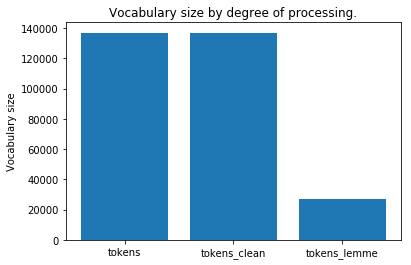

In [48]:
plt.bar(range(3), [len(VOCAB), len(VOCAB_CLEAN), len(VOCAB_LEMME)])
plt.xticks(range(3), LABELS)
plt.ylabel('Vocabulary size')
plt.xlabel('')
plt.title('Vocabulary size by degree of processing.')
plt.show()

#### sentence lengths

In [49]:
pd.Series(sentence_lengths).describe()

count    568454.000000
mean         83.006127
std          82.779668
min           3.000000
25%          34.000000
50%          58.000000
75%         101.000000
max        3519.000000
dtype: float64

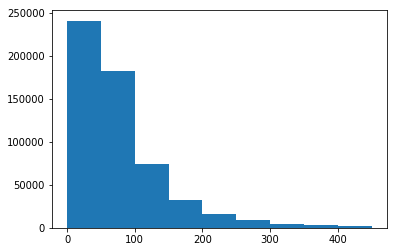

In [50]:
plt.hist(sentence_lengths, bins=np.arange(0, 500, 50))
plt.show()

In [51]:
sentence_lengths_pos = [len(tokens) for tokens in pos_data['tokens_flat']]
sentence_lengths_neu = [len(tokens) for tokens in neu_data['tokens_flat']]
sentence_lengths_neg = [len(tokens) for tokens in neg_data['tokens_flat']]
sentence_lengths_all = [sentence_lengths_pos, sentence_lengths_neu, sentence_lengths_neg]

In [52]:
print([np.mean(sen) for sen in sentence_lengths_all])
print([np.median(sen) for sen in sentence_lengths_all])

[79.90117108367491, 99.299999999999997, 91.333313017297073]
[55.0, 72.0, 66.0]


In [53]:
def show_plots(data_pts, n_row=1, n_col=3, figsize=(15, 6), title_name='Histogram'):
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    n_pts = n_row*n_col
    data_pts = data_pts[:n_pts]
    
    for i, data_pt in enumerate(data_pts):
        plt.subplot(n_row, n_col, i+1)
        plt.hist(data_pt, bins=np.arange(0,500,25))
        plt.title(title_name, fontsize=10)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)

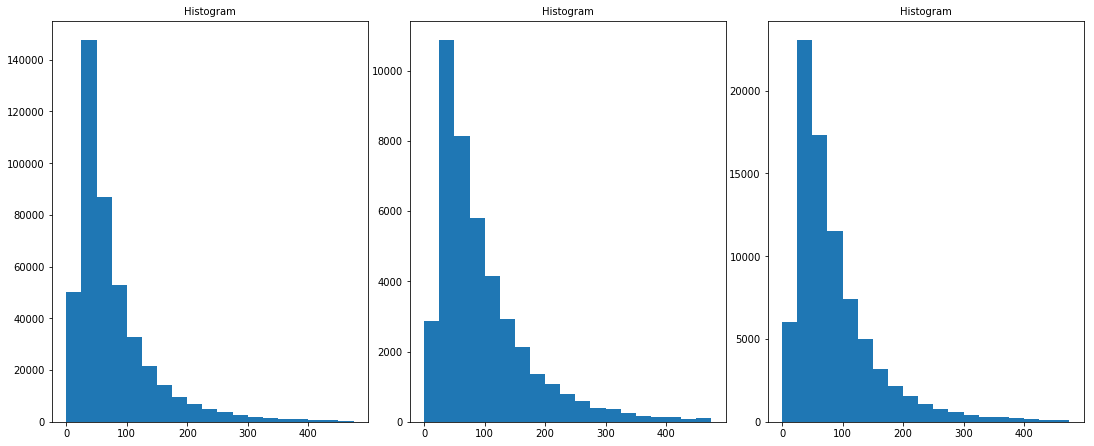

In [54]:
show_plots(sentence_lengths_all)

## 4. word embeddings

We want to capture the semantic meaning of words, meaning we need to understand that words like ‘good’ and ‘positive’ are closer than ‘apricot’ and ‘continent.’ The tool we will use to help us capture meaning is called Word2Vec.

**Using pre-trained words**

Word2Vec is a technique to find continuous embeddings for words. It learns from reading massive amounts of text and memorizing which words tend to appear in similar contexts. After being trained on enough data, it generates a 300-dimension vector for each word in a vocabulary, with words of similar meaning being closer to each other.

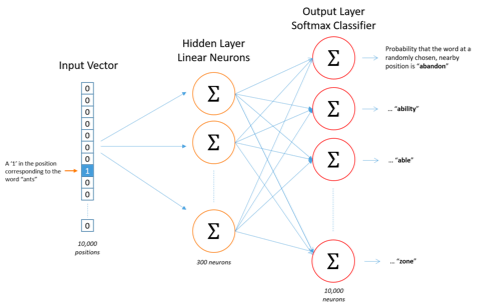

In [287]:
Image(filename='../img/skip_gram.png')

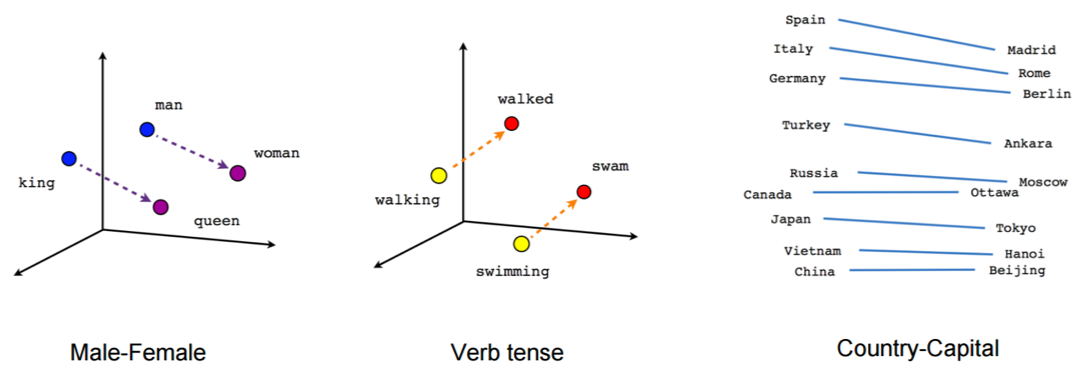

In [288]:
Image(filename='../img/w2v.png')

In [55]:
EMBEDDING_DIM=300

### 4.a. load word2vec (Google)

In [56]:
wor2vec_path = os.path.join(data_path, 'word2vec/GoogleNews-vectors-negative300.bin.gz')
word2vec = gensim.models.KeyedVectors.load_word2vec_format(wor2vec_path, binary=True)

### 4.b. load glove

In [57]:
def load_glove(glove_path):
    f = open(glove_path,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = [float(val) for val in splitLine[1:]]
        model[word] = embedding
    return model

In [58]:
glove_path = os.path.join(data_path, 'glove/glove.6B.300d.txt')

glove = load_glove(glove_path)

### 4.c. load word2vec (custom-made)

In [59]:
from gensim.models.word2vec import Word2Vec

# train custom-made word2vec
def train_word2vec_model(n_dim, min_count, list_sentences, corpus_size, epochs):
    vec_model = Word2Vec(size=n_dim, min_count=min_count)
    vec_model.build_vocab(list_sentences)
    vec_model.train(list_sentences, total_examples=corpus_size, epochs=epochs)
    return vec_model

In [60]:
cols = ['tokens' + syntax + '_flat' for syntax in syntaxes]
cols

['tokens_flat', 'tokens_clean_flat', 'tokens_lemme_flat']

In [61]:
w2v_custom = [train_word2vec_model(n_dim=EMBEDDING_DIM, min_count=10, list_sentences=list(data_clean[col]), corpus_size=len(all_words), epochs=10) for col in cols]

### 4.d. benchmark and visualize

In [62]:
embeddings_labels = ['w2v', 'amz', 'glv']

In [63]:
embedding_dict = {'w2v':word2vec, 'amz':w2v_custom, 'glv':glove}
embedding_dict_simple = {'w2v':word2vec, 'amz':w2v_custom[2], 'glv':glove}

In [64]:
def get_average_word2vec(tokens_list, w2v, generate_missing=False, k=300):

    if len(tokens_list) < 1:
        return np.zeros(k)

    if generate_missing:
        vectorized = [w2v[word] if word in w2v else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [w2v[word] if word in w2v else np.zeros(k) for word in tokens_list]

    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    
    return averaged

In [65]:
def average_vectors(vectors, k=300):
    length = len(vectors)
    if length > 0:
        try:
            summed = np.sum(vectors, axis=0)
            averaged = np.divide(summed, length)
        except:
            averaged = np.zeros(k)
    else:
        averaged = np.zeros(k)
    return averaged

In [66]:
def get_word2vec_embeddings(embedding_representation, list_sentences, flat=False, generate_missing=False):
    embeddings = [get_average_word2vec(sublist, embedding_representation, generate_missing=generate_missing) for sublist in list_sentences]
    if not flat:
        embeddings = average_vectors(embeddings)
    return embeddings

In [67]:
def add_embedding(df, embedding_representation, output_prefix, flat=False, generate_missing=False):
    #df[output_prefix] = df['tokens'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    #df[output_prefix + '_clean'] = df['tokens_clean'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    df[output_prefix + '_lemme'] = df['tokens_lemme'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    return df

In [68]:
def add_data_embeddings(df, embedding_dict, flat=False, generate_missing=False):
    for key, value in embedding_dict.items():
        print(' -- Adding ' + key +  ' embedding -- ')
        df = add_embedding(df, value, key)
    return df

In [69]:
data_clean = add_data_embeddings(data_clean, embedding_dict_simple)

 -- Adding w2v embedding -- 
 -- Adding amz embedding -- 
 -- Adding glv embedding -- 


In [70]:
data_clean.columns

Index(['ProductId', 'Score', 'Summary', 'Text', 'Sentiment', 'ClassLabel',
       'list_sentences', 'tokens', 'tokens_clean', 'tokens_lemme',
       'tokens_flat', 'tokens_clean_flat', 'tokens_lemme_flat', 'w2v_lemme',
       'amz_lemme', 'glv_lemme'],
      dtype='object')

In [71]:
embeddings_w2v, embeddings_amz, embeddings_glv = [data_clean[col + '_lemme'].tolist() for col in embeddings_labels]

In [72]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

%matplotlib inline
from pylab import *

In [73]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    print(color_mapper)
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['green','blue', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        green_patch = mpatches.Patch(color='green', label='Positive')
        red_patch = mpatches.Patch(color='red', label='Negative')
        blue_patch = mpatches.Patch(color='blue', label='Neutral')
        plt.legend(handles=[green_patch, red_patch, blue_patch])

In [74]:
x=embeddings_w2v
y=data_clean.ClassLabel.tolist()

In [77]:
data_clean.Sentiment.value_counts()

Positive    443777
Negative     82037
Neutral      42640
Name: Sentiment, dtype: int64

{1: 0, 2: 1, 3: 2}


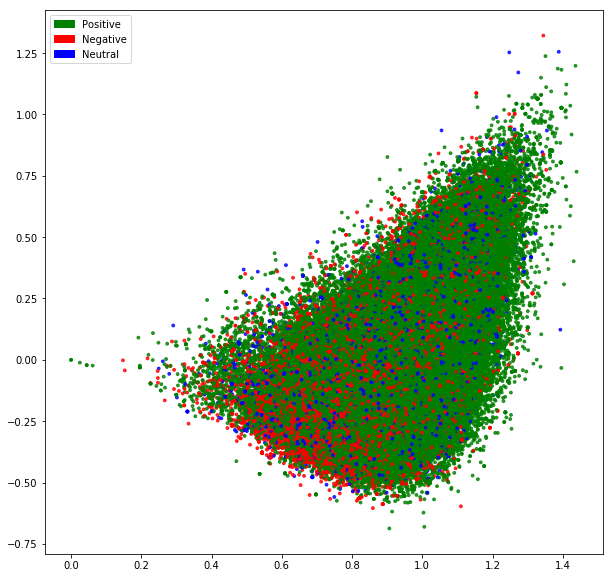

In [75]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(x, y)
plt.show()

## 5. balance dataset

In [78]:
output_label = 'Sentiment'

In [79]:
def balance_dataset(df, output_label, sampling_type):
    
    unique_outputs = list(set(df[output_label].tolist()))

    datasets = [df.loc[df[output_label]==item] for item in unique_outputs]
    sizes = [item.shape[0] for item in datasets]
    min_size = min(sizes)
    max_size = max(sizes)

    if sampling_type=="over":
        result_df = pd.concat([data.sample(max_size, replace=True) for data in datasets])
    elif sampling_type=="down":
        result_df = pd.concat([data.sample(min_size) for data in datasets])
        
    result_df.reset_index(drop=True, inplace=True)
    return result_df

In [216]:
balanced_data_clean = balance_dataset(data_clean, output_label, sampling_type="down")

In [217]:
print('Balanced dataset shape :', balanced_data_clean.shape)

Balanced dataset shape : (127920, 16)


In [218]:
balanced_data_clean.Sentiment.value_counts()

Negative    42640
Neutral     42640
Positive    42640
Name: Sentiment, dtype: int64

In [220]:
balanced_data_clean = balanced_data_clean.loc[balanced_data_clean.Sentiment!='Neutral']
balanced_data_clean.reset_index(drop=True, inplace=True)

In [122]:
embeddings_w2v_blcd, embeddings_amz_blcd, embeddings_glv_blcd = [balanced_data_clean[col + '_lemme'].tolist() for col in embeddings_labels]

In [123]:
x=embeddings_amz_blcd
y=balanced_data_clean.ClassLabel.tolist()

{1: 0, 3: 1}


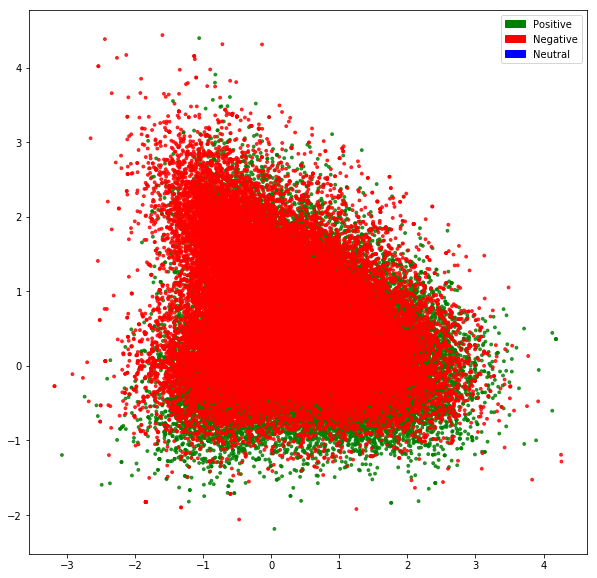

In [124]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(x, y)
plt.show()

## 6. Classification tasks

**Vectors** : 
- `X_w2v`
- `X_amz`
- `X_glv`

**Labels** :
- `y`

In [125]:
X_w2v, X_amz, X_glv = [balanced_data_clean[col + '_lemme'].tolist() for col in embeddings_labels]
y = balanced_data_clean.ClassLabel.tolist()

In [126]:
from sklearn.model_selection import train_test_split

def generate_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    return X_train, X_test, y_train, y_test

In [127]:
X_w2v_train, X_w2v_test, y_train, y_test = generate_data(X_w2v, y)
X_amz_train, X_amz_test, _, _ = generate_data(X_amz, y)
X_glv_train, X_glv_test, _, _ = generate_data(X_glv, y)

### 6.a Starting simple : Logistic Regression and SVM

In [166]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

% time clf.fit(X_w2v_train, y_train)
y_w2v_predicted = clf.predict(X_w2v_test)

% time clf.fit(X_glv_train, y_train)
y_glv_predicted = clf.predict(X_glv_test)

% time clf.fit(X_amz_train, y_train)
y_amz_predicted = clf.predict(X_amz_test)

CPU times: user 15.3 s, sys: 48.5 s, total: 1min 3s
Wall time: 1min 20s
CPU times: user 12.5 s, sys: 27.9 s, total: 40.4 s
Wall time: 57 s
CPU times: user 12.8 s, sys: 30.3 s, total: 43.1 s
Wall time: 52.6 s


In [129]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [130]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_w2v_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.828, precision = 0.828, recall = 0.828, f1 = 0.828


In [131]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_amz_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.864, precision = 0.864, recall = 0.864, f1 = 0.864


In [132]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_glv_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.826, precision = 0.826, recall = 0.826, f1 = 0.825


In [133]:
from sklearn import svm
clf = svm.LinearSVC(random_state=40)

% time clf.fit(X_w2v_train, y_train)
y_w2v_predicted = clf.predict(X_w2v_test)

% time clf.fit(X_amz_train, y_train)
y_amz_predicted = clf.predict(X_amz_test)

% time clf.fit(X_glv_train, y_train)
y_glv_predicted = clf.predict(X_glv_test)

CPU times: user 7.81 s, sys: 1.88 s, total: 9.69 s
Wall time: 11.2 s
CPU times: user 51.9 s, sys: 1.83 s, total: 53.7 s
Wall time: 54.4 s
CPU times: user 32.7 s, sys: 1.74 s, total: 34.5 s
Wall time: 35.3 s


In [134]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_w2v_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.828, precision = 0.828, recall = 0.828, f1 = 0.828


In [135]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_amz_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.863, precision = 0.863, recall = 0.863, f1 = 0.863


In [136]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_glv_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.824, precision = 0.824, recall = 0.824, f1 = 0.824


### 👉 Let's look at how each model is performing by looking at the confusion matrix

In [146]:
from sklearn.metrics import confusion_matrix
import itertools

cm_w2v = confusion_matrix(y_test, y_w2v_predicted)
cm_amz = confusion_matrix(y_test, y_amz_predicted)
cm_glv = confusion_matrix(y_test, y_glv_predicted)

In [141]:
cm_w2v

array([[6920, 1568],
       [1363, 7205]])

In [142]:
cm_amz

array([[7305, 1183],
       [1148, 7420]])

In [143]:
cm_glv

array([[6876, 1612],
       [1388, 7180]])

In [147]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [260]:
'''fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_amz, classes=['Positive','negative'], normalize=False, title='Confusion matrix')
plt.show()'''

"fig = plt.figure(figsize=(10, 10))\nplot = plot_confusion_matrix(cm_amz, classes=['Positive','negative'], normalize=False, title='Confusion matrix')\nplt.show()"

### 👉 From now we can inspect further the variables importance and start understanding how our models are classifying comments

In [188]:
balanced_data_clean.head()

ProductId  Score               Summary  \
42640  B0061IUIDY      4        Really not bad   
42641  B003MOXA6C      5             Delicious   
42642  B000F959NO      4  Pleasantly surprised   
42643  B005LMLZF6      5      Me Gusta Guayusa   
42644  B0000CNU3F      5     Fantastic noodles   

                                                    Text Sentiment  \
42640  comparing this to adagio chai which is what i ...  Positive   
42641  the think thin products are well made and glut...  Positive   
42642  i've never been a big fan of thai tea, but my ...  Positive   
42643  as a tea-junkie, runa's traditional guayusa of...  Positive   
42644  my husband loves these noodles.  his mother us...  Positive   

       ClassLabel                                     list_sentences  \
42640           1  [comparing this to adagio chai which is what i...   
42641           1  [the think thin products are well made and glu...   
42642           1  [i've never been a big fan of thai tea, but my...   
42643           1  [as a tea-junkie, runa's traditional guayusa o...   
42644           1  [my husband loves these noodles., his mother u...   

                                                  tokens  \
42640  [[comparing, this, to, adagio, chai, which, is...   
42641  [[the, think, thin, products, are, well, made,...   
42642  [[i, ve, never, been, a, big, fan, of, thai, t...   
42643  [[as, a, tea, junkie, runa, s, traditional, gu...   
42644  [[my, husband, loves, these, noodles], [his, m...   

                                            tokens_clean  \
42640  [[comparing, adagio, chai, normally, drink, di...   
42641  [[think, thin, products, well, made, gluten, f...   
42642  [[never, big, fan, thai, tea, husband, loves, ...   
42643  [[tea, junkie, runa, traditional, guayusa, off...   
42644  [[husband, loves, noodles], [mother, used, mak...   

                                            tokens_lemme  \
42640  [[compare, adagio, normally, drink, different,...   
42641  [[think, thin, product, well, make, gluten, fr...   
42642  [[never, big, fan, thai, tea, husband, love, l...   
42643  [[tea, junkie, traditional, offer, simple, agr...   
42644  [[husband, love, noodle], [mother, use, make, ...   

                                             tokens_flat  \
42640  [comparing, this, to, adagio, chai, which, is,...   
42641  [the, think, thin, products, are, well, made, ...   
42642  [i, ve, never, been, a, big, fan, of, thai, te...   
42643  [as, a, tea, junkie, runa, s, traditional, gua...   
42644  [my, husband, loves, these, noodles, his, moth...   

                                       tokens_clean_flat  \
42640  [comparing, adagio, chai, normally, drink, dif...   
42641  [think, thin, products, well, made, gluten, fr...   
42642  [never, big, fan, thai, tea, husband, loves, l...   
42643  [tea, junkie, runa, traditional, guayusa, offe...   
42644  [husband, loves, noodles, mother, used, make, ...   

                                       tokens_lemme_flat  \
42640  [compare, adagio, normally, drink, different, ...   
42641  [think, thin, product, well, make, gluten, fre...   
42642  [never, big, fan, thai, tea, husband, love, lo...   
42643  [tea, junkie, traditional, offer, simple, agre...   
42644  [husband, love, noodle, mother, use, make, hap...   

                                               w2v_lemme  \
42640  [0.0579167, 0.033923, 0.0409675, 0.109221, -0....   
42641  [-0.0178559, 0.01361, -0.0613598, 0.172966, -0...   
42642  [-0.0148396, 0.0317085, -0.0384923, 0.159851, ...   
42643  [0.00878047, 0.0200649, -0.0293285, 0.119671, ...   
42644  [-0.00993213, -0.0379372, 0.0281183, 0.144883,...   

                                               amz_lemme  \
42640  [0.0676358, 0.436837, 0.198933, 0.251733, -0.4...   
42641  [0.232408, -0.348597, 0.336451, -0.249562, 0.0...   
42642  [-0.0801418, 0.198909, -0.0458287, -0.00680431...   
42643  [0.191234, 0.275309, -0.13796, 0.220459, -0.17...   
42644  [0.0526466, 0.23569

In [268]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(balanced_data_clean.Text,
                                                                        balanced_data_clean.ClassLabel,
                                                                        test_size=0.2,
                                                                        random_state=40)
vector_store = embedding_dict_simple['amz']

def word2vec_pipeline(examples):
    global vector_storea
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf.predict_proba(tokenized_list)

#c = make_pipeline(count_vectorizer, clf)

In [269]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Positive","Negative"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [273]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

visualize_one_exp(X_test_data, y_test_data, 32945)

Index: 32945
True class: Negative


In [178]:
visualize_one_exp(X_test_data, y_test_data, 78899)

Index: 78899
True class: Negative


In [174]:
visualize_one_exp(X_test_data, y_test_data, 50430)

Index: 50430
True class: Negative


In [274]:
len(list(X_test_data))

17056

In [281]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
            'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Negative',
    1: 'Positive',
    2: 'Neutral'
}

sorted_contributions = get_statistical_explanation(list(X_test_data), 100, word2vec_pipeline, label_to_text)

In [282]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample

top_words = sorted_contributions['Positive']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Positive']['supporters'][:10].tolist()

bottom_words = sorted_contributions['Positive']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Positive']['detractors'][:10].tolist()

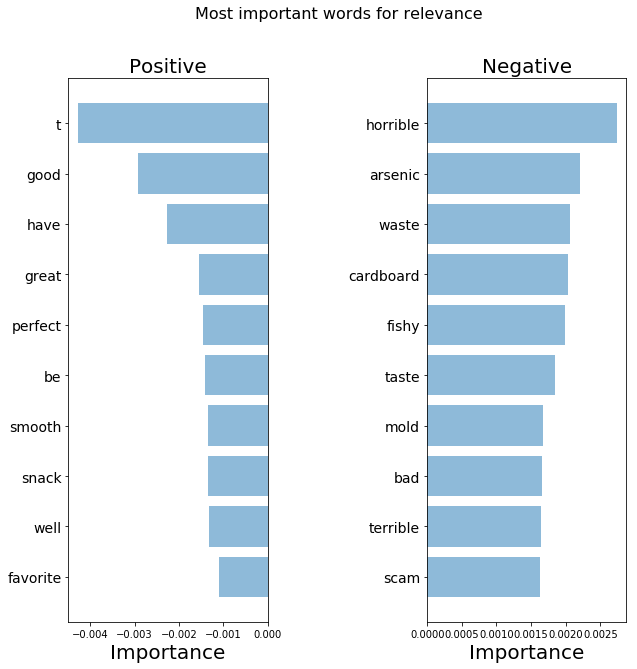

In [284]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### 6.b Leveraging text structure and deep learning

We’ve covered quick and efficient approaches to generate compact sentence embeddings. However, by omitting the order of words, we are discarding all of the syntactic information of our sentences. If these methods do not provide sufficient results, you can utilize more complex model that take in whole sentences as input and predict labels without the need to build an intermediate representation. A common way to do that is to treat a sentence as a sequence of individual word vectors using either Word2Vec or more recent approaches such as GloVe or CoVe. This is what we will do below.

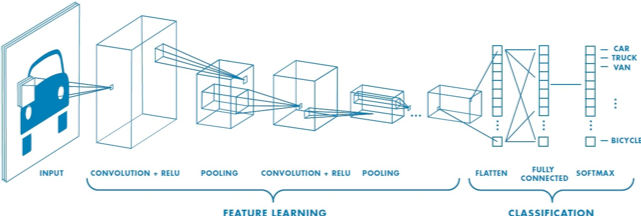

In [289]:
Image(filename='../img/cnn_vision.png')

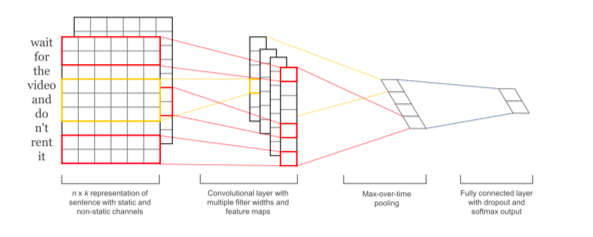

In [290]:
Image(filename='../img/cnn_text.png')

In [221]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(balanced_data_clean["Text"].tolist())
sequences = tokenizer.texts_to_sequences(balanced_data_clean["Text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

balanced_data_clean["NewClassLabel"] = balanced_data_clean["ClassLabel"].map({1:0, 3:1})

labels = to_categorical(np.asarray(balanced_data_clean["NewClassLabel"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word,index in word_index.items():
    embedding_weights[index,:] = embedding_dict_simple['amz'][word] if word in embedding_dict_simple['amz'] else np.random.rand(EMBEDDING_DIM)

print(embedding_weights.shape)

Found 61001 unique tokens.
(61002, 300)


In [222]:
balanced_data_clean["ClassLabel"].value_counts()

3    42640
1    42640
Name: ClassLabel, dtype: int64

In [223]:
balanced_data_clean["NewClassLabel"].value_counts()

1    42640
0    42640
Name: NewClassLabel, dtype: int64

In [224]:
from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [227]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(balanced_data_clean["ClassLabel"].unique())), False)

/Users/mhadji/anaconda3/envs/nlp_3/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [295]:
model_hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

Train on 68224 samples, validate on 17056 samples
Epoch 1/5
68224/68224 [==============================] - 84s 1ms/step - loss: 0.2005 - acc: 0.9201 - val_loss: 0.3493 - val_acc: 0.8627
Epoch 2/5
68224/68224 [==============================] - 85s 1ms/step - loss: 0.1741 - acc: 0.9310 - val_loss: 0.3527 - val_acc: 0.8630
Epoch 3/5
68224/68224 [==============================] - 90s 1ms/step - loss: 0.1580 - acc: 0.9371 - val_loss: 0.3669 - val_acc: 0.8676
Epoch 4/5
68224/68224 [==============================] - 81s 1ms/step - loss: 0.1419 - acc: 0.9439 - val_loss: 0.3772 - val_acc: 0.8661
Epoch 5/5
68224/68224 [==============================] - 85s 1ms/step - loss: 0.1270 - acc: 0.9499 - val_loss: 0.3816 - val_acc: 0.8661


### 6.c Going further : fasttext

[fastText](https://github.com/facebookresearch/fastText) is a library for efficient learning of word representations and sentence classification developed by Facebook Research

In [232]:
balanced_data_clean.head()

ProductId  Score                                        Summary  \
0  B000DT7QE6      4                           The Dogs are pleased   
1  B007TJGZ4A      4                                  Keurig Coffee   
2  B0053T153E      4                   Nice, Healthy Treat for Dogs   
3  B003A9S5JG      4  Between 3 and 4 stars - nice, but not superbe   
4  B001E530J8      5                     Yuban Coffee/33 ounce cans   

                                                Text Sentiment  ClassLabel  \
0  both grand-dogs love this product and the pric...  Positive           1   
1  i like this coffee a lot.  also the gloria jea...  Positive           1   
2  i love these healthy dog treats. my dog has tr...  Positive           1   
3  nice but i prefer by far the stick version. if...  Positive           1   
4  <a href=":www.amazon.comgpproductb001e530j8">y...  Positive           1   

                                      list_sentences  \
0  [both grand-dogs love this product and the pri...   
1  [i like this coffee a lot., also the gloria je...   
2  [i love these healthy dog treats., my dog has ...   
3  [nice but i prefer by far the stick version., ...   
4  [<a href=":www.amazon.comgpproductb001e530j8">...   

                                              tokens  \
0  [[both, grand, dogs, love, this, product, and,...   
1  [[i, like, this, coffee, a, lot], [also, the, ...   
2  [[i, love, these, healthy, dog, treats], [my, ...   
3  [[nice, but, i, prefer, by, far, the, stick, v...   
4  [[a, href, www, amazon, comgpproductb001e530j8...   

                                        tokens_clean  \
0  [[grand, dogs, love, product, price, good], [p...   
1  [[like, coffee, lot], [also, gloria, jean, var...   
2  [[love, healthy, dog, treats], [dog, trouble, ...   
3  [[nice, prefer, far, stick, version], [like, v...   
4  [[href, www, amazon, comgpproductb001e530j8, y...   

                                        tokens_lemme  \
0  [[grand, dog, love, product, price, good], [pa...   
1  [[like, coffee, lot], [also, jean, variety, pa...   
2  [[love, healthy, dog, treat], [dog, trouble, l...   
3  [[nice, prefer, far, stick, version], [like, v...   
4  [[www, amazon, original, grind, coffee, 33, ou...   

                                         tokens_flat  \
0  [both, grand, dogs, love, this, product, and, ...   
1  [i, like, this, coffee, a, lot, also, the, glo...   
2  [i, love, these, healthy, dog, treats, my, dog...   
3  [nice, but, i, prefer, by, far, the, stick, ve...   
4  [a, href, www, amazon, comgpproductb001e530j8,...   

                                   tokens_clean_flat  \
0  [grand, dogs, love, product, price, good, pack...   
1  [like, coffee, lot, also, gloria, jean, variet...   
2  [love, healthy, dog, treats, dog, trouble, lot...   
3  [nice, prefer, far, stick, version, like, vegg...   
4  [href, www, amazon, comgpproductb001e530j8, yu...   

                                   tokens_lemme_flat  \
0  [grand, dog, love, product, price, good, packa...   
1  [like, coffee, lot, also, jean, variety, pack,...   
2  [love, healthy, dog, treat, dog, trouble, lot,...   
3  [nice, prefer, far, stick, version, like, vegg...   
4  [www, amazon, original, grind, coffee, 33, oun...   

                                           w2v_lemme  \
0  [0.0600993, 0.021342, -0.0213521, 0.0943756, -...   
1  [0.0382402, 0.0368875, -0.117437, 0.222941, 0....   
2  [0.0450698, 0.0646508, -0.0468021, 0.151586, -...   
3  [0.0295166025559, 0.0363525388141, 0.034314981...   
4  [0.0247612114996, -0.0258573005597, -0.0269392...   

                                           amz_lemme  \
0  [-0.134466, -0.0287059, -0.221088, -0.132306, ...   
1  [0.0335292, 0.137646, 0.241716, 0.376314, -0.0...   
2  [0.0910685, -0.346317, -0.00843094, -0.253235,...   
3  [0.0337490799526, -0.0900580529124, 0.17982660...   
4  [-0.408981, -0.0520766, 0.133885, -0.271611, -...   

                                           glv_lemme  NewClassLabel  
0  [-

In [236]:
def add_fasttext_columns(df, shuffle=False, label_prefix='__label__'):
    
    if shuffle:
        df.sample(frac=1).reset_index(drop=True)

    df['Sentiment_ft'] = label_prefix + df['Sentiment'].apply(lambda s : "".join(s.split())) + ' '
    df['Comment_clean'] = df['tokens_flat'].apply(lambda x : ' '.join(x))
    df['Comment_ft'] = ' ' + df['Comment_clean'] + ' '
    return df

balanced_data_clean = add_fasttext_columns(balanced_data_clean)

In [237]:
balanced_data_clean[['Comment_ft', 'Sentiment_ft']].head()

Comment_ft        Sentiment_ft
0   both grand dogs love this product and the pri...  __label__Positive 
1   i like this coffee a lot also the gloria jean...  __label__Positive 
2   i love these healthy dog treats my dog has tr...  __label__Positive 
3   nice but i prefer by far the stick version if...  __label__Positive 
4   a href www amazon comgpproductb001e530j8 yuba...  __label__Positive

In [238]:
data_labels = ['train', 'test']

In [240]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(balanced_data_clean,
                                                                        balanced_data_clean.ClassLabel,
                                                                        test_size=0.2,
                                                                        random_state=40)

In [258]:
import fasttext

def fit_fasttext():
    data_file_ft = [os.path.join(data_path, '_data_ft.' + data_label) for data_label in data_labels]
    train_file_ft, test_file_ft = data_file_ft
    [x.to_csv(y, header=None, index=False, columns=['Sentiment_ft','Comment_ft']) for x,y in zip([X_train_data, X_test_data], data_file_ft)]
    model_file = os.path.join(model_path, 'fasttext_model')
    classifier = fasttext.supervised(train_file_ft, model_file, dim=30, lr=0.1, epoch=15, min_count=1, word_ngrams=3, bucket=10000000, thread=12, label_prefix='__label__')
    result = classifier.test(test_file_ft)
    f1_score = 2*(result.precision*result.recall)/(result.precision + result.recall)
    print('fasttext F1-score :', f1_score)

In [259]:
fit_fasttext()

fasttext F1-score : 0.9371482176360225


## 7. Final results  🎉

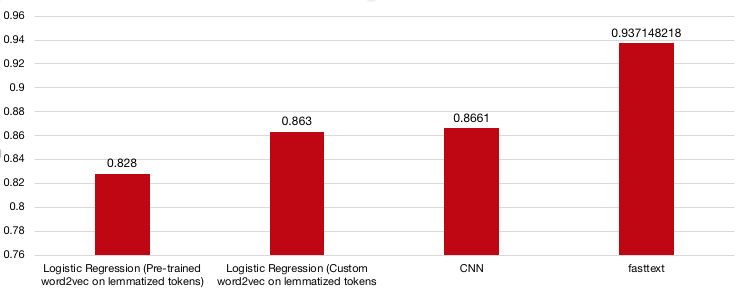

In [296]:
Image(filename='../img/model_comparison.png')